## Answer the following

1. Aggregate the Sales_Qty for each Store-SKU at a month level; detect any Outliers in the Sales_Qty for each Store-SKU combination and apply an outlier treatment on the same.
Specify the outlier treatment technique.  


2. Estimate the level of promotions (Discount%) for each Category-Store level at a month level - remove any outliers / inconsistencies from this, and specify the technique used; the level of promotions is defined as $$Discount\% = (1 - sum of SP / sum of MRP)$$  


3. Estimate the inventory levels at a weekly level for each Store-SKU by interpolating missing values from data on secondary and primary sales; the following equation holds true in general: (you can do this for a shorter period of Jan 2017 to Mar 2017) 
$$Closing\ inventory\ on\ day\ [t] = Closing\ inventory\ on\ day\ [t-1] $$
$$                                - Secondary(sales - returns)\ on\ day\ [t] $$
$$                                + Primary (sales - returns)\ on\ day\ [t]$$
    NOTE:
        a. Secondary sales is the file named “WC_DS_Ex1_Sec_Sales.csv” - and it refers to sales from stores to customers (and returns by customers)
        b. Primary sales is the file name “WC_DS_Ex1_Pri_Sales.csv” - and it refers to stock movements from retailer WH to stores (and returns back to WH)
        c. Returns in both datasets are indicated by negative values in ‘Sales_Qty’ and ‘Qty’ fields respectively  


4. The inventory estimations in Question 3 will have data inconsistencies - take any assumption to resolve them and explain that assumption  


5. Using the Secondary sales data and inventory series from Question 3, determine average out-of-stock percentage (OOS%) for each Category-Store combination at a monthly level; the OOS % is defined as: 
$$ OOS\% = 1 - \{Average\ of\ no.\ of\ unique\ SKUs\ in\ stock\ each\ day / No.\ of\ unique\ SKUs\ in\ stock\ over\ the\ entire\ month\}$$ (for each Category-Store combination each month)
( Again - do this for a short period of Jan 2017 - Mar 2017; for forecasting you can
assume that the retailer will experience similar OOS levels in Jan-Mar 2018 )   


6. Using the historical secondary sales, inventory series, OOS% levels and promotion levels, determine the demand for each Store-SKU combination at a monthly level for the forecast period; use any forecasting technique that you’re comfortable with (you may use multiple techniques)  


7. Explain the approach for Question 6 clearly e.g. dividing data into train, validation and test sets, choice of technique used, metric(s) used to evaluate the results   


8. If any of the above steps is becoming computationally too expensive or taking too long; you are free to either simplify them or reduce the complexity (e.g. impute weekly inventory positions instead of daily)   

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from lib import datasetPrimAnalysis, namestr, splitTimeSeriesData, createKey
# warnings.filterwarnings("ignore")
# plt.style.use('fivethirtyeight')
# matplotlib.rcParams['axes.labelsize'] = 14
# matplotlib.rcParams['xtick.labelsize'] = 12
# matplotlib.rcParams['ytick.labelsize'] = 12
# matplotlib.rcParams['text.color'] = 'k'

In [2]:
## Reading Data
# df = pd.read_excel("Superstore.xls")

primDf = pd.read_csv('data/WC_DS_Ex1_Pri_Sales.csv')
secDf = pd.read_csv('data/WC_DS_Ex1_Sec_Sales.csv')
invDf = pd.read_csv('data/WC_DS_Ex1_Inv.csv')

df_li = {'Secondary': secDf, 
         'Primary':primDf, 
         'Inventory': invDf
        }

## transfering the feature "SKU_Code" to object and then viewing the result
for df_name in df_li:
    print('"{}" dataframe shape:  {}'.format(df_name, df_li[df_name].shape))
    
    ## Changing feature data type to object
    df_li[df_name][['SKU_Code']] = df_li[df_name][['SKU_Code']].astype(str)
    
    ## Changing feature data type to datetime
    # df_li[df_name]['Date'] = [ datetime.strptime(ele, '%Y-%m-%d') for ele in df_li[df_name]['Date'] ] # %H:%M:%S
    df_li[df_name]['Date'] = pd.to_datetime(df_li[df_name]['Date'],format='%Y-%m-%d') 
    
    ## sorting df based on Date
    df_li[df_name].sort_values(by=['Date'], inplace=True)
    df_li[df_name].reset_index(drop=True, inplace=True)
    
    display(df_li[df_name].head())
    _ = datasetPrimAnalysis(df_li[df_name])
    print('****'*25,'\n\n')



"Secondary" dataframe shape:  (24554, 7)


,Store_Code,SKU_Code,Category,Date,Sales_Qty,MRP,SP
0,Store3,603693,Cat1,2016-01-01,1,1095.0,1095.0
1,Store3,614427,Cat2,2016-01-01,1,645.0,645.0
2,Store1,610221,Cat1,2016-01-01,1,1095.0,808.7
3,Store2,600252,Cat1,2016-01-01,1,1095.0,808.7
4,Store3,600960,Cat2,2016-01-01,1,795.0,795.0


Overall dataset shape : (24554, 7)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,24554,700,2017-10-31,757,2016-01-01,2017-12-31,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,24554,3,Store3,10957,"[Store3, Store1, Store2]",0.0
SKU_Code,0,object,0,24554,2321,600852,112,"[603693, 614427, 610221, 600252, 600960, 60135...",0.0
Category,0,object,0,24554,4,Cat2,9428,"[Cat1, Cat2, Cat4, Cat3]",0.0


____________| Number of feature/s which are Quantitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
Sales_Qty,0,int64,0,24554.0,0.911827,0.416639,-1.0,1.0,1.0,1.0,2.0,0.0
MRP,0,float64,0,24554.0,894.296449,512.014141,-2195.0,745.0,945.0,1095.0,3590.0,0.0
SP,0,float64,0,24554.0,797.072665,472.947315,-2195.0,645.0,836.5,1030.2,3590.0,0.0


**************************************************************************************************** 


"Primary" dataframe shape:  (21115, 5)


,Store_Code,SKU_Code,Category,Date,Qty
0,Store1,603132,Cat1,2015-12-11,2
1,Store1,614490,Cat2,2015-12-11,1
2,Store3,603819,Cat2,2015-12-11,2
3,Store3,603810,Cat2,2015-12-11,1
4,Store3,603417,Cat3,2015-12-11,1


Overall dataset shape : (21115, 5)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,21115,66,2017-03-31,1428,2015-12-11,2017-12-25,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,21115,3,Store3,8109,"[Store1, Store3, Store2]",0.0
SKU_Code,0,object,0,21115,2463,603804,39,"[603132, 614490, 603819, 603810, 603417, 60314...",0.0
Category,0,object,0,21115,4,Cat1,10048,"[Cat1, Cat2, Cat3, Cat4]",0.0


____________| Number of feature/s which are Quantitative : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
Qty,0,int64,0,21115.0,1.048307,1.64839,-12.0,1.0,1.0,2.0,30.0,0.0


**************************************************************************************************** 


"Inventory" dataframe shape:  (58835, 5)


,Store_Code,SKU_Code,Category,Date,SOH
0,Store3,602994,Cat1,2016-06-27,1
1,Store2,600366,Cat4,2016-06-27,1
2,Store1,600366,Cat4,2016-06-27,5
3,Store3,600366,Cat4,2016-06-27,4
4,Store2,600369,Cat4,2016-06-27,1


Overall dataset shape : (58835, 5)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,58835,19,2017-08-22,3751,2016-06-27,2017-12-21,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,58835,3,Store1,21748,"[Store3, Store2, Store1]",0.0
SKU_Code,0,object,0,58835,2283,600366,113,"[602994, 600366, 600369, 600384, 600372, 60037...",0.0
Category,0,object,0,58835,4,Cat1,23015,"[Cat1, Cat4, Cat2, Cat3]",0.0


____________| Number of feature/s which are Quantitative : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
SOH,0,int64,0,58835.0,1.951355,1.227142,1.0,1.0,2.0,2.0,15.0,0.0


**************************************************************************************************** 




## Answering Some primary Question

Analyzing the number of unique product present in each store.


,Store_Code,Category,SKU_Code,unique_SKU_Cnt
0,Store1,Cat1,"[610221, 603738, 603540, 603138, 603519, 60174...",828
1,Store1,Cat2,"[614466, 610371, 603846, 603795, 609942, 60935...",523
2,Store1,Cat3,"[607617, 604329, 604377, 610020, 604365, 61005...",91
3,Store1,Cat4,"[602772, 600348, 602760, 609840, 602568, 60256...",392
4,Store2,Cat1,"[600252, 601446, 600186, 601509, 610221, 60133...",785
5,Store2,Cat2,"[603894, 609915, 603882, 603879, 603876, 60989...",525
6,Store2,Cat3,"[610035, 604335, 604326, 603438, 610005, 60436...",83
7,Store2,Cat4,"[609852, 602601, 609825, 609768, 609765, 60028...",401
8,Store3,Cat1,"[603693, 601353, 601521, 610347, 609234, 60174...",979
9,Store3,Cat2,"[614427, 600960, 614460, 601038, 614472, 60080...",574


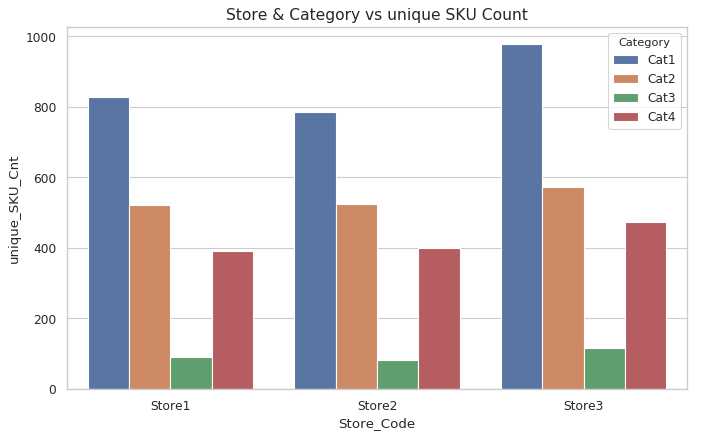

In [5]:
temp_DF = secDf.copy()
## Are all category present in all stores
print('Analyzing the number of unique product present in each store.')
tempDF = pd.DataFrame(temp_DF.groupby(by= ['Store_Code', 'Category'])['SKU_Code'].unique().sort_index())
tempDF.reset_index(inplace=True)
tempDF['unique_SKU_Cnt'] = tempDF['SKU_Code'].apply(lambda x: len(x))
display(tempDF)
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
sns.set(style="whitegrid")
sns.barplot(x= 'Store_Code', y= 'unique_SKU_Cnt', hue='Category', data= tempDF)
plt.title('Store & Category vs unique SKU Count', fontsize=14)
plt.show()

#### Discussion
Averge number of unique products :  $Store3$ > $Store1$ > $Store2$  

Averge number of unique products :  $Cat1$ > $Cat2$ > $Cat4$ > $Cat3$

In [6]:
## Are unique product sold through
print('Analyzing Are unique product sold through.')

tempDF = pd.DataFrame(temp_DF.groupby(by= ['Store_Code', 'Date', 'Category'])['SKU_Code'].unique().sort_index())
tempDF.reset_index(inplace=True)
tempDF['unique_SKU_Cnt'] = tempDF['SKU_Code'].apply(lambda x: len(x))

tempDF.set_index('Date', inplace=True)
display(tempDF.head(15))

Analyzing Are unique product sold through.


,Store_Code,Category,SKU_Code,unique_SKU_Cnt
Date,,,,
2016-01-01,Store1,Cat1,"[610221, 603738, 603540, 603138, 603519, 60174...",9
2016-01-01,Store1,Cat2,"[614466, 610371, 603846, 603795]",4
2016-01-02,Store1,Cat1,"[601347, 615999, 603003, 600147, 601740, 60018...",14
2016-01-02,Store1,Cat2,"[609942, 609351]",2
2016-01-02,Store1,Cat4,"[602772, 600348]",2
2016-01-03,Store1,Cat1,"[610287, 601740, 610581, 609423, 601710, 60151...",21
2016-01-03,Store1,Cat2,"[609942, 614484, 601146, 603795, 614478, 61041...",9
2016-01-03,Store1,Cat4,"[602760, 609840]",2
2016-01-04,Store1,Cat1,"[609423, 609228, 603546]",3


2016
Store1


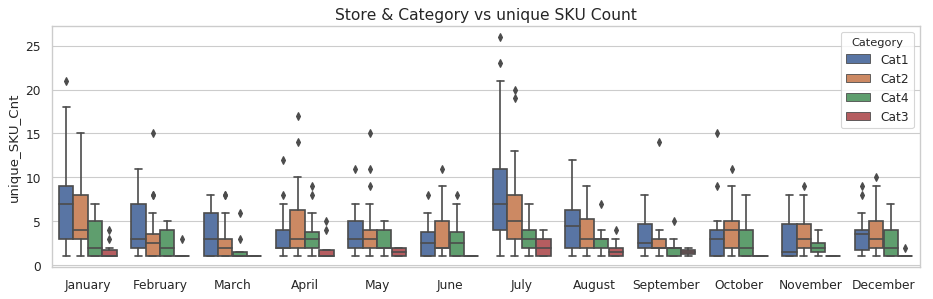

Store2


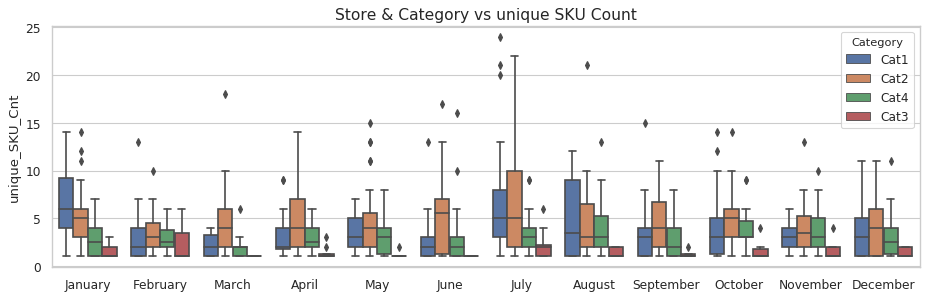

Store3


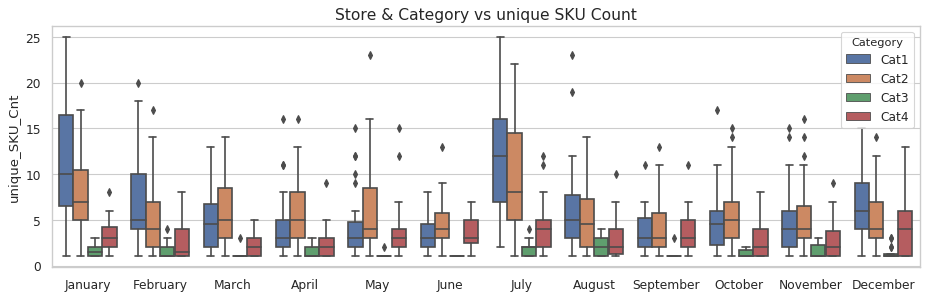

2017
Store1


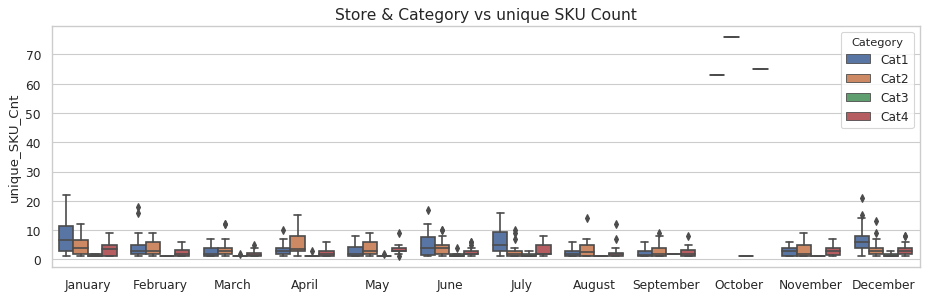

Store2


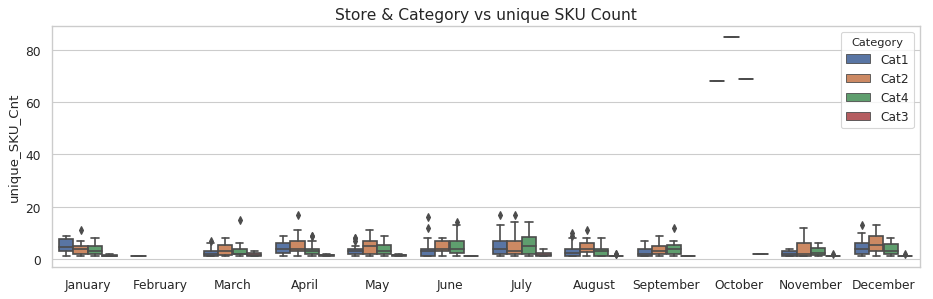

Store3


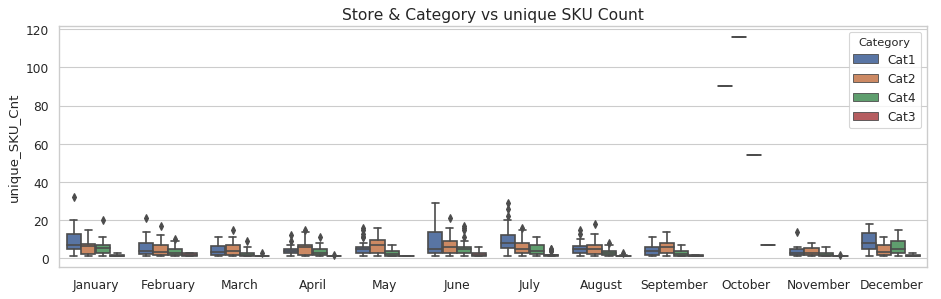

In [7]:
# 
for yr in range(min(tempDF.index).year, max(tempDF.index).year+1):
    print(yr)
    t = tempDF.loc[tempDF.index.year == yr,:]
    
    for sto in tempDF['Store_Code'].unique():
        print(sto)
        ts = t.loc[t['Store_Code']== sto, :]#.reset_index()
        mon = [ ele.month_name() for ele in ts.index ]
#         display(ts)
        plt.figure(num=None, figsize=(14, 4), dpi=80, facecolor='w', edgecolor='k')
        sns.set(style="whitegrid")
        ax = sns.boxplot(x= mon, y= 'unique_SKU_Cnt', hue='Category', data= ts)
        # ax = sns.swarmplot(x= mon, y= 'unique_SKU_Cnt', hue='Category', data= ts, color=".25")
#         sns.catplot(x= mon, y= 'unique_SKU_Cnt', hue='Category', col='Store_Code', data= ts, kind="box",
#                    #x="sex", y="total_bill", hue="smoker", col="time", data=tips, kind="box",
#                    height=4, aspect=.7)
        plt.title('Store & Category vs unique SKU Count', fontsize=14)
        plt.show()

## Answering Question Number 1
1. Aggregate the Sales_Qty for each Store-SKU at a month level; detect any Outliers in the Sales_Qty for each Store-SKU combination and apply an outlier treatment on the same.
Specify the outlier treatment technique.  

In [8]:
## Approximate Run Time = 750 sec (approx)
from problem1Code import question1

result1DF = question1(df_li)
display(result1DF)

Execution start at 1551464724
Analyzing and PreProcessing the Data
"Secondary" dataframe shape:  (24554, 7)
Overall dataset shape : (24554, 7)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,24554,700,2017-10-31,757,2016-01-01,2017-12-31,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,24554,3,Store3,10957,"[Store3, Store2, Store1]",0.0
SKU_Code,0,object,0,24554,2321,600852,112,"[603693, 609219, 601338, 603795, 600807, 60170...",0.0
Category,0,object,0,24554,4,Cat2,9428,"[Cat1, Cat2, Cat4, Cat3]",0.0


____________| Number of feature/s which are Quantitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
Sales_Qty,0,int64,0,24554.0,0.911827,0.416639,-1.0,1.0,1.0,1.0,2.0,0.0
MRP,0,float64,0,24554.0,894.296449,512.014141,-2195.0,745.0,945.0,1095.0,3590.0,0.0
SP,0,float64,0,24554.0,797.072665,472.947315,-2195.0,645.0,836.5,1030.2,3590.0,0.0


**************************************************************************************************** 


TimeTaken 1 sec

Selecting the Data according to the mentioned Date Range ("2016-01-01" - "2017-12-31")
Processing Data Month-wise
TimeTaken 0 sec

Adding Observations for the month for which are data is not present in the dataset.
Filling values in the newly created observation.
TimeTaken 27 sec

Checking for the outlier cases. 
Note: Since we have very less number of observations in Store-SKU pair and additionally we are not ablle to commment properly on the trend. Therefore finding outlier is a challenge
TimeTaken 670 sec

Treating Outlier Observations.
TimeTaken 41 sec

Whole Execution Time 739 sec



,Store_Code,SKU_Code,YrMonName,Sales_Qty,isOutlier
0,Store1,600003,2016-01,0.0,False
1,Store1,600003,2016-02,1.0,False
2,Store1,600003,2016-03,0.0,False
3,Store1,600003,2016-04,0.0,False
4,Store1,600003,2016-05,0.0,False
5,Store1,600003,2016-06,2.0,False
6,Store1,600003,2016-07,0.0,False
7,Store1,600003,2016-08,0.0,False
8,Store1,600003,2016-09,0.0,False
9,Store1,600003,2016-10,0.0,False


In [9]:
singleProd = result1DF.loc[ (result1DF['Store_Code'] == 'Store1') & (result1DF['SKU_Code'] == '600024'), : ]
print('Product hass seen :', 'NoSale' if sum(singleProd['Sales_Qty']) == 0 else 'Sales of {} Qty'.format(sum(singleProd['Sales_Qty'])))
display(singleProd)

## limitaions are there with IQR
# mask = singleProd['Sales_Qty'].between(singleProd['Sales_Qty'].quantile(.25), singleProd['Sales_Qty'].quantile(.75), inclusive=True)
# iqr = singleProd.loc[mask, 'Sales_Qty']
# iqr

## Zscore
std = singleProd['Sales_Qty'].std()
mean = singleProd['Sales_Qty'].mean()
zscore = [ (ele - mean) / std for ele in singleProd['Sales_Qty'] ]
outlier = (pd.Series(zscore) > 3) |(pd.Series(zscore) < -3)
print('std: ', std, '\nmean:', mean, '\nzscore:', zscore)

Product hass seen : Sales of 5.0 Qty


,Store_Code,SKU_Code,YrMonName,Sales_Qty,isOutlier
144,Store1,600024,2016-01,0.0,False
145,Store1,600024,2016-02,1.0,False
146,Store1,600024,2016-03,0.0,False
147,Store1,600024,2016-04,0.0,False
148,Store1,600024,2016-05,0.0,False
149,Store1,600024,2016-06,1.0,False
150,Store1,600024,2016-07,0.0,False
151,Store1,600024,2016-08,1.0,False
152,Store1,600024,2016-09,0.0,False
153,Store1,600024,2016-10,0.0,False


std:  0.4148511169990534 
mean: 0.20833333333333334 
zscore: [-0.5021881942620121, 1.9083151381956458, -0.5021881942620121, -0.5021881942620121, -0.5021881942620121, 1.9083151381956458, -0.5021881942620121, 1.9083151381956458, -0.5021881942620121, -0.5021881942620121, -0.5021881942620121, -0.5021881942620121, 1.9083151381956458, -0.5021881942620121, -0.5021881942620121, -0.5021881942620121, -0.5021881942620121, -0.5021881942620121, -0.5021881942620121, -0.5021881942620121, -0.5021881942620121, -0.5021881942620121, 1.9083151381956458, -0.5021881942620121]


For sophisticatedticated models will require the novel data or clean data to  

very small number of Data points 

## Answer to Question 2

2. Estimate the level of promotions (Discount%) for each Category-Store level at a month level - remove any outliers / inconsistencies from this, and specify the technique used; the level of promotions is defined as $$Discount\% = (1 - sum of SP / sum of MRP)$$ 

In [10]:
## Approximate Run Time = 2 sec (approx)
from problem2Code import question2

result2DF = question2(df_li)
display(result2DF)

Execution start at 1551465463
Analyzing and PreProcessing the Data
"Secondary" dataframe shape:  (24554, 7)
Overall dataset shape : (24554, 7)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,24554,700,2017-10-31,757,2016-01-01,2017-12-31,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,24554,3,Store3,10957,"[Store3, Store1, Store2]",0.0
SKU_Code,0,object,0,24554,2321,600852,112,"[603693, 601740, 614427, 610221, 600252, 60096...",0.0
Category,0,object,0,24554,4,Cat2,9428,"[Cat1, Cat2, Cat4, Cat3]",0.0


____________| Number of feature/s which are Quantitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
Sales_Qty,0,int64,0,24554.0,0.911827,0.416639,-1.0,1.0,1.0,1.0,2.0,0.0
MRP,0,float64,0,24554.0,894.296449,512.014141,-2195.0,745.0,945.0,1095.0,3590.0,0.0
SP,0,float64,0,24554.0,797.072665,472.947315,-2195.0,645.0,836.5,1030.2,3590.0,0.0


**************************************************************************************************** 


TimeTaken 1 sec

Selecting the Data according to the mentioned Date Range ("2016-01-01" - "2017-12-31")
Processing Data Month-wise
TimeTaken 0 sec

Adding Observations for the month for which are data is not present in the dataset.
Filling values in the newly created observation.
TimeTaken 0 sec

Checking for the outlier cases. 
Note: Since we have very less number of observations in Store-SKU pair and additionally we are not ablle to commment properly on the trend. Therefore finding outlier is a challenge
TimeTaken 1 sec

Treating Outlier Observations.
TimeTaken 0 sec

Calculating Discount Percentage, Category-Store-month wise
Dropping Unnecessary columns
TimeTaken 0 sec

Whole Execution Time 2 sec



,Category,Store_Code,YrMonName,Sales_Qty,MRP,SP,discountPct
0,Cat1,Store1,2016-01,210,240200.0,195312.90,18.687386
1,Cat1,Store1,2016-02,106,120670.0,103036.50,14.612994
2,Cat1,Store1,2016-03,79,95155.0,95155.00,0.000000
3,Cat1,Store1,2016-04,82,88690.0,88590.00,0.112752
4,Cat1,Store1,2016-05,70,77000.0,77000.00,0.000000
5,Cat1,Store1,2016-06,50,56850.0,54062.00,4.904134
6,Cat1,Store1,2016-07,240,296600.0,192428.50,35.121881
7,Cat1,Store1,2016-08,100,117750.0,94523.50,19.725265
8,Cat1,Store1,2016-09,46,53270.0,53270.00,0.000000
9,Cat1,Store1,2016-10,80,99100.0,96532.00,2.591322


## Answering Question Number 3

3. Estimate the inventory levels at a **weekly level** for each Store-SKU by interpolating missing values from data on secondary and primary sales; the following equation holds true in general: (you can do this for a shorter period of Jan 2017 to Mar 2017) 
$$Closing\ inventory\ on\ day\ [t] = Closing\ inventory\ on\ day\ [t-1] $$
$$                                - Secondary(sales - returns)\ on\ day\ [t] $$
$$                                + Primary (sales - returns)\ on\ day\ [t]$$
    NOTE:
        a. Secondary sales is the file named “WC_DS_Ex1_Sec_Sales.csv” - and it refers to sales from stores to customers (and returns by customers)
        b. Primary sales is the file name “WC_DS_Ex1_Pri_Sales.csv” - and it refers to stock movements from retailer WH to stores (and returns back to WH)
        c. Returns in both datasets are indicated by negative values in ‘Sales_Qty’ and ‘Qty’ fields respectively  

In [11]:
## Approximate Run Time = 30 sec (approx)
from problem3Code import question3

result3DF = question3(df_li)
display(result3DF)

Execution start at 1551465465
Analyzing and PreProcessing the Data
"Secondary" dataframe shape:  (24554, 7)
Overall dataset shape : (24554, 7)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,24554,700,2017-10-31,757,2016-01-01,2017-12-31,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,24554,3,Store3,10957,"[Store3, Store2, Store1]",0.0
SKU_Code,0,object,0,24554,2321,600852,112,"[603693, 601704, 609219, 601338, 603795, 60080...",0.0
Category,0,object,0,24554,4,Cat2,9428,"[Cat1, Cat2, Cat4, Cat3]",0.0


____________| Number of feature/s which are Quantitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
Sales_Qty,0,int64,0,24554.0,0.911827,0.416639,-1.0,1.0,1.0,1.0,2.0,0.0
MRP,0,float64,0,24554.0,894.296449,512.014141,-2195.0,745.0,945.0,1095.0,3590.0,0.0
SP,0,float64,0,24554.0,797.072665,472.947315,-2195.0,645.0,836.5,1030.2,3590.0,0.0


**************************************************************************************************** 


"Primary" dataframe shape:  (21115, 5)
Overall dataset shape : (21115, 5)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,21115,66,2017-03-31,1428,2015-12-11,2017-12-25,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,21115,3,Store3,8109,"[Store1, Store2, Store3]",0.0
SKU_Code,0,object,0,21115,2463,603804,39,"[603132, 609864, 610614, 614436, 610617, 61444...",0.0
Category,0,object,0,21115,4,Cat1,10048,"[Cat1, Cat4, Cat2, Cat3]",0.0


____________| Number of feature/s which are Quantitative : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
Qty,0,int64,0,21115.0,1.048307,1.64839,-12.0,1.0,1.0,2.0,30.0,0.0


**************************************************************************************************** 


Combining Secondary and Primary Datasets
DataFrame Shape (43290, 5)
TimeTaken 2 sec

Selecting the Data according to the mentioned Date Range ("2017-01-01" - "2017-03-31")
New DataFrame Shape (4959, 5)
TimeTaken 0 sec

Working on determining adequate initial value
TimeTaken 8 sec

Dropping columns
Processing Data Weeky-wise
TimeTaken 0 sec

Adding Observations for the month for which are data is not present in the dataset.
TimeTaken 3 sec

Filling values via interpolation in the newly created observation.
TimeTaken 18 sec

Whole Execution Time 31 sec



,Store_Code,SKU_Code,Week,LeastPossibleClosingInvOfWeek
0,Store1,600012,week_01,0
1,Store1,600012,week_02,0
2,Store1,600012,week_03,0
3,Store1,600012,week_04,0
4,Store1,600012,week_05,0
5,Store1,600012,week_06,0
6,Store1,600012,week_07,1
7,Store1,600012,week_08,1
8,Store1,600012,week_09,1
9,Store1,600012,week_10,1


Question: Number of Inventory we sshould have at the begining

DailyFluctuation = [1, -1, -4, -2, 5, 3] 

So if we start with x at the begening then the total stored inventory will fluctuate like
[x+1, x, x-4, x-6, x+1, x+4]

if x= 0 then we can say that this is   
CumulativeFluctuation = [1, 0, -4, -6, 1, 4]
So the mininmum vallue that x will have soo that the stored quantity is always >=0 is x=6 in the emaple  above



## Answer the following 4

4. The inventory estimations in Question 3 will have data inconsistencies - take any assumption to resolve them and explain that assumption 

In [12]:
## Approximate Run Time = 12 sec (approx)
from problem4Code import question4

result4DF = question4(df_li)
display(result4DF)

Execution start at 1551465496
Analyzing and PreProcessing the Data
"Secondary" dataframe shape:  (24554, 7)
Overall dataset shape : (24554, 7)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,24554,700,2017-10-31,757,2016-01-01,2017-12-31,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,24554,3,Store3,10957,"[Store3, Store2, Store1]",0.0
SKU_Code,0,object,0,24554,2321,600852,112,"[603693, 602970, 601740, 614427, 610221, 60025...",0.0
Category,0,object,0,24554,4,Cat2,9428,"[Cat1, Cat2, Cat4, Cat3]",0.0


____________| Number of feature/s which are Quantitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
Sales_Qty,0,int64,0,24554.0,0.911827,0.416639,-1.0,1.0,1.0,1.0,2.0,0.0
MRP,0,float64,0,24554.0,894.296449,512.014141,-2195.0,745.0,945.0,1095.0,3590.0,0.0
SP,0,float64,0,24554.0,797.072665,472.947315,-2195.0,645.0,836.5,1030.2,3590.0,0.0


**************************************************************************************************** 


"Primary" dataframe shape:  (21115, 5)
Overall dataset shape : (21115, 5)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,21115,66,2017-03-31,1428,2015-12-11,2017-12-25,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,21115,3,Store3,8109,"[Store1, Store3, Store2]",0.0
SKU_Code,0,object,0,21115,2463,603804,39,"[603132, 614490, 603819, 603810, 603417, 60314...",0.0
Category,0,object,0,21115,4,Cat1,10048,"[Cat1, Cat2, Cat3, Cat4]",0.0


____________| Number of feature/s which are Quantitative : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
Qty,0,int64,0,21115.0,1.048307,1.64839,-12.0,1.0,1.0,2.0,30.0,0.0


**************************************************************************************************** 


"Inventory" dataframe shape:  (58835, 5)
Overall dataset shape : (58835, 5)
____________| Number of feature/s which are Time based : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,first,last,%Missing
Date,0,datetime64[ns],0,58835,19,2017-08-22,3751,2016-06-27,2017-12-21,0.0


____________| Number of feature/s which are Qualitative : 3 |____________


,IsNullSum,dtypes,IsNaSum,count,unique,top,freq,CategoriesName,%Missing
Store_Code,0,object,0,58835,3,Store1,21748,"[Store3, Store1, Store2]",0.0
SKU_Code,0,object,0,58835,2283,603897,113,"[602994, 602988, 602982, 602979, 602985, 60295...",0.0
Category,0,object,0,58835,4,Cat1,23015,"[Cat1, Cat4, Cat2, Cat3]",0.0


____________| Number of feature/s which are Quantitative : 1 |____________


,IsNullSum,dtypes,IsNaSum,count,mean,std,min,25%,50%,75%,max,%Missing
SOH,0,int64,0,58835.0,1.951355,1.227142,1.0,1.0,2.0,2.0,15.0,0.0


**************************************************************************************************** 


Combining Secondary and Primary Datasets
DataFrame Shape (43290, 5)
TimeTaken 3 sec

Selecting the Data according to the mentioned Date Range ("2017-01-01" - "2017-03-31")
New DataFrame Shape (4959, 5)
TimeTaken 0 sec

Working on determining adequate initial value
TimeTaken 8 sec

Dropping columns
TimeTaken 0 sec

Joining The Inventory Dataset
TimeTaken 1 sec

Whole Execution Time 12 sec



,Store_Code,SKU_Code,Date,Sales_Qty,Qty,LeastPossibleClosingInvOfDay,SOH
0,Store1,600003,2017-01-27,NaN,NaN,NaN,4.0
1,Store1,600003,2017-02-21,NaN,NaN,NaN,4.0
2,Store1,600003,2017-03-21,NaN,NaN,NaN,4.0
3,Store1,600006,2017-01-27,NaN,NaN,NaN,2.0
4,Store1,600006,2017-02-21,NaN,NaN,NaN,2.0
5,Store1,600006,2017-03-21,NaN,NaN,NaN,2.0
6,Store1,600009,2017-01-27,NaN,NaN,NaN,1.0
7,Store1,600009,2017-02-21,NaN,NaN,NaN,1.0
8,Store1,600009,2017-03-21,NaN,NaN,NaN,1.0
9,Store1,600012,2017-01-27,NaN,NaN,NaN,1.0


#### Discussion
From General Inspection Some of the things which can be observed are highllighted below
- Our assumptions/ Method to estimate the least posssible inventory being present in store seems to holding well. 
- There are multiple products has neither been sold or replenished. eg. in store "Store1" and for the sku "600003", "600006".
- There are some cases where either the data is inconsistent/ or unaccountabilty for the SKU is present. eg. in store "Store1" and for the sku "600012" and enev "600015", we see in increment in the accounted quantity on "2017-03-21", which should have happend on "2017-02-15" i.e. after the product was received from the warehouse. 
-- It is believed that some delay is involved ---check this one

All of this can be be properly calculated/ accounted.

Note: Since this new Dataset is not able to bring out anything that is relevant and is also resulting in some inconconsistency, hence we won't be using this dataset and instead we will be using "totQua" dataset. 
This dataset resolution is to a day level, and in the present problem statement ask us to deal at weekly level. Hence further on we will be working at weekly level, using week number as an indicator.

## Answer the following 5

5. Using the Secondary sales data and inventory series from Question 3, determine average out-of-stock percentage (OOS%) for each Category-Store combination at a monthly level; the OOS % is defined as: 
$$ OOS\% = 1 - \{Average\ of\ no.\ of\ unique\ SKUs\ in\ stock\ each\ day / No.\ of\ unique\ SKUs\ in\ stock\ over\ the\ entire\ month\}$$ (for each Category-Store combination each month)
( Again - do this for a short period of Jan 2017 - Mar 2017; for forecasting you can
assume that the retailer will experience similar OOS levels in Jan-Mar 2018 )   

In [17]:
## Loading Dataset to generate estimate on Quantity
temp_sDF, temp_pDF = secDf.copy(), primDf.copy()
temp_pDF = pd.DataFrame(temp_pDF.groupby(by= ['Store_Code', 'Category', 'SKU_Code', 'Date'])['Qty'].sum().sort_index())#.reset_index()
temp_sDF = pd.DataFrame(temp_sDF.groupby(by= ['Store_Code', 'Category', 'SKU_Code', 'Date'])['Sales_Qty'].sum().sort_index())#.reset_index()
totQua = temp_sDF.join(temp_pDF, how='outer').reset_index().fillna(0)

## Working with Smalller Data which liess between Jan2017 and Mar 2017
totQua = totQua.loc[(totQua['Date'] > '2017-01-01') & (totQua['Date'] <= '2017-03-31'), :]
totQua.reset_index(drop=True, inplace=True)

## Determioning the adequate initial value
totQua['QtyCn'] = totQua['Qty'].subtract(totQua['Sales_Qty'])
adQn = totQua.groupby(by=['Store_Code', 'Category', 'SKU_Code', 'Date'])['QtyCn'].sum()
adQn = adQn.groupby(['Store_Code', 'Category', 'SKU_Code']).cumsum() ## Cumulation over 'Storecode' & Sku
cumQuant = adQn
adQn = adQn.groupby(['Store_Code', 'Category', 'SKU_Code']).min()
totQua.drop(columns=['QtyCn'], inplace=True)

## Adding Closing Inventory 
totQua['ClosingInvOfDayWhenBaseIsZero'] = list(cumQuant) ##0 ---> this value is not 

## Adding an assumed initial quantity
templi = []
for index, row in totQua.iterrows():
    val = adQn[row['Store_Code']][row['Category']][row['SKU_Code']] * -1
    templi.append(0 if val <=0  else val)

totQua['BaseValToAdd'] = templi ## i.e. x in the series

## Adding The Final relavent Column
totQua['LeastPossibleClosingInvOfDay'] = totQua['ClosingInvOfDayWhenBaseIsZero'].add(totQua['BaseValToAdd'])

## Dropping Unnecessary Columns
# totQua.drop(columns=['ClosingInvOfDayWhenBaseIsZero', 'BaseValToAdd'], inplace=True)

## Resultant DataFrame --- Result Shown using groupby
agg_Qty = totQua.groupby(by=['Store_Code', 'Category', 'SKU_Code', 'Date']).sum().sort_index()

# display(agg_Qty.first())

In [18]:
## Inventory 
### Have to take as multiple inventory is present in only in Inventory as it was not sold.

temp_iDF = invDf.copy()

## Working with Smalller Data which liess between Jan2017 and Mar 2017
temp_iDF = temp_iDF.loc[(temp_iDF['Date'] > '2017-01-01') & (temp_iDF['Date'] <= '2017-03-31'), :]
temp_iDF.reset_index(drop=True, inplace=True)

temp_iDF = pd.DataFrame(temp_iDF.groupby(by= ['Store_Code', 'Category', 'SKU_Code', 'Date'])['SOH'].sum().sort_index())#.reset_index()
# display(temp_pDF.head())

OverQua = agg_Qty.join(temp_iDF, how='outer').reset_index()#.fillna(0)

## observing the DF
OverQua.groupby(by=['Store_Code', 'Category', 'SKU_Code', 'Date']).first()


Sales_Qty  Qty  \
Store_Code Category SKU_Code Date                         
Store1     Cat1     600003   2017-01-27        NaN  NaN   
                             2017-02-21        NaN  NaN   
                             2017-03-21        NaN  NaN   
                    600006   2017-01-27        NaN  NaN   
                             2017-02-21        NaN  NaN   
                             2017-03-21        NaN  NaN   
                    600009   2017-01-27        NaN  NaN   
                             2017-02-21        NaN  NaN   
                             2017-03-21        NaN  NaN   
                    600012   2017-01-27        NaN  NaN   
                             2017-02-15        0.0  1.0   
                             2017-02-21        NaN  NaN   
                             2017-03-21        NaN  NaN   
                    600015   2017-01-27        NaN  NaN   
                             2017-02-15        0.0  1.0   
                             2017-02-21        NaN  NaN   
                             2017-03-21        NaN  NaN   
                    600018   2017-01-27        NaN  NaN   
                             2017-02-21        NaN  NaN   
                             2017-03-21        NaN  NaN   
                    600021   2017-01-27        NaN  NaN   
                             2017-02-21        NaN  NaN   
                             2017-03-21        NaN  NaN   
                    600024   2017-01-18        1.0  0.0   
                             2017-02-15        0.0  1.0   
                             2017-03-21        NaN  NaN   
                    600027   2017-01-27        NaN  NaN   
                             2017-02-21        NaN  NaN   
                             2017-03-21        NaN  NaN   
                    600030   2017-01-27        NaN  NaN   
...                                            ...  ...   
Store3     Cat4     625272   2017-02-04        0.0  2.0   
                             2017-03-21        NaN  NaN   
                    625275   2017-02-04        0.0  2.0   
                             2017-03-21        NaN  NaN   
                    625278   2017-02-04        0.0  3.0   
                             2017-03-21        NaN  NaN   
                    625281   2017-02-04        0.0  3.0   
                             2017-03-21        NaN  NaN   
                    625284   2017-02-04        0.0  2.0   
                             2017-03-03        1.0  0.0   
                             2017-03-21        NaN  NaN   
                    625287   2017-02-04        0.0  3.0   
                             2017-03-06        1.0  0.0   
                             2017-03-21        NaN  NaN   
                    625290   2017-02-04        0.0  3.0   
                             2017-03-21        NaN  NaN   
                    625293   2017-02-04        0.0  2.0   
                             2017-03-21        NaN  NaN   
                    625296   2017-02-04        0.0  2.0   
                             2017-03-21        NaN  NaN   
                    625299   2017-02-04        0.0  2.0   
                             2017-03-21        NaN  NaN   
                    625302   2017-02-04        0.0  2.0   
                             2017-03-21        NaN  NaN   
                    625305   2017-02-04        0.0  3.0   
                             2017-03-21        NaN  NaN   
                    625308   2017-02-04        0.0  3.0   
                             2017-03-21        NaN  NaN   
                    625311   2017-02-04        0.0  2.0   
                             2017-03-21        NaN  NaN   

                                         ClosingInvOfDayWhenBaseIsZero  \
Store_Code Category SKU_Code Date                                        
Store1     Cat1     600003   2017-01-27                            NaN   
                             2017-02-21                            NaN   
                           

In [ ]:
## splitting the dataset
split_date = pd.datetime(2017, 6, 1)
for df_name in df_li:
    '''    x='qwe'; x1= 'asd';  exec("%s = %d; %s = %d" % (x,2,x1,3)); print(qwe, asd)
    '''
    print(df_name)
    varName = namestr(df_li[df_name], globals())[0]
    exec("{0}, {1} = splitTimeSeriesData(df_li[df_name], split_date)".format(varName+'_train', varName+'_test'))

print('\nOriginal "Primary" DataFrame Shape: {} \n\tTrain Shape: {}\tTest Shape:{}'.format(
    primDf.shape, primDf_train.shape, primDf_test.shape))




6. Using the historical secondary sales, inventory series, OOS% levels and promotion levels, determine the demand for each Store-SKU combination at a monthly level for the forecast period; use any forecasting technique that you’re comfortable with (you may use multiple techniques)  


7. Explain the approach for Question 6 clearly e.g. dividing data into train, validation and test sets, choice of technique used, metric(s) used to evaluate the results   


8. If any of the above steps is becoming computationally too expensive or taking too long; you are free to either simplify them or reduce the complexity (e.g. impute weekly inventory positions instead of daily)   

In [ ]:
## is Time Difference between series uniform and if it is, then what is the time difference

In [ ]:
## Dickey Fuller Test: This is one of the statistical tests for checking stationarity.

from statsmodels.tsa.stattools import adfuller
ts = primDf_train['Qty']

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    # rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts)